In [1]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
from tensorflow.python.keras import regularizers
from keras.initializers import Constant
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data=pd.read_csv('clean-HARD.csv')
data

,Unnamed: 0,rating,sentences
0,20778,1,فندق واداره لايهمه الزبون وفريق متعالي لاشئ لد...
1,78562,5,منتجع ممتاز للاستجمام لدي الكثير لاكتبه المنتج...
2,53746,5,استثنائي الفندق جدا جمييل للغايه ملاحظه ولم يت...
3,53679,5,استثنائي الفندق جدا جمييل للغايه ملاحظه ولم يت...
4,82383,4,بشكل عام بالنسبه لموقعه المترو مو بعيد مره تقد...
...,...,...,...
105693,67270,5,جميل جميل
105694,67232,4,رائع السرير
105695,18308,5,استثنائي لاشيء
105696,18414,5,لايوجد الاستقبال لايوجد


In [3]:
data.sentences=data.sentences.astype(str)

In [4]:
sequence_length = 512 #300
max_features = 20000 # this is the number of words we care about

#fit the tokenizer onto the text.
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(data['sentences'].values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(data['sentences'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(data['rating']).values

# lets keep  back 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)  

print("test set size " + str(len(X_test)))
print("train set size " + str(len(X_train)))


test set size 10570
train set size 95128


In [5]:
import numpy as np
embeddings_index = {}
f = open('GloVe-Arabic/vectorsHARD.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:] ,dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 21587 word vectors.


In [6]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 126890 unique tokens.


In [7]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim =200

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

20001


In [8]:
num_filters = 100
inputs = Input(shape=(sequence_length,), dtype='int32')

# note the `trainable=False`, later we will make this layer trainable
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(inputs)

reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

dropout = Dropout(0.1)(flatten)
output = Dense(units=4, activation='softmax')(dropout)   

In [9]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 200)     4000200     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 512, 200, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 510, 1, 100)  60100       ['reshape[0][0]']                
                                                                                              

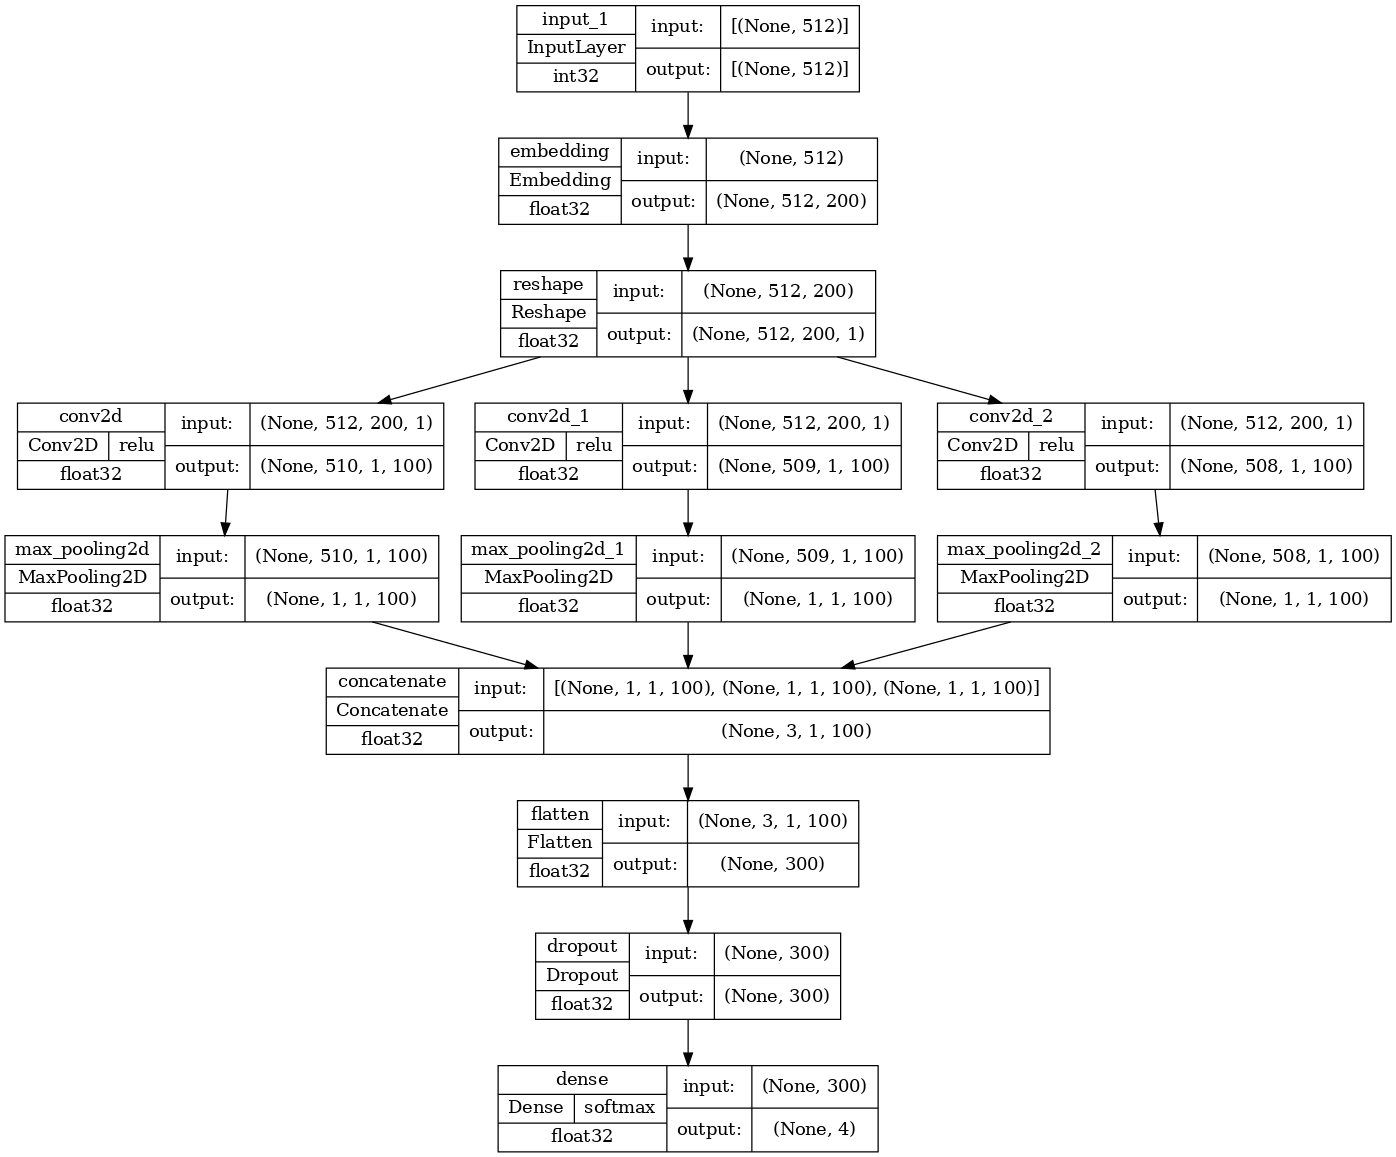

In [10]:
tf.keras.utils.plot_model(
    model,
    to_file="CNN_HARD.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=90,
    layer_range=None,
    show_layer_activations=True,
)

In [11]:
batch_size =128   
history = model.fit(X_train, y_train, epochs=15, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/15
669/669 [==============================] - 15s 15ms/step - loss: 1.3640 - accuracy: 0.6369 - val_loss: 1.2956 - val_accuracy: 0.6115
Epoch 2/15
669/669 [==============================] - 10s 15ms/step - loss: 1.2037 - accuracy: 0.6807 - val_loss: 1.4647 - val_accuracy: 0.6040
Epoch 3/15
669/669 [==============================] - 10s 15ms/step - loss: 1.1753 - accuracy: 0.6911 - val_loss: 1.2178 - val_accuracy: 0.6871
Epoch 4/15
669/669 [==============================] - 10s 15ms/step - loss: 1.1409 - accuracy: 0.6984 - val_loss: 1.0809 - val_accuracy: 0.7184
Epoch 5/15
669/669 [==============================] - 10s 15ms/step - loss: 1.1227 - accuracy: 0.7055 - val_loss: 1.1407 - val_accuracy: 0.6671
Epoch 6/15
669/669 [==============================] - 10s 15ms/step - loss: 1.1059 - accuracy: 0.7075 - val_loss: 1.0315 - val_accuracy: 0.7231
Epoch 7/15
669/669 [==============================] - 10s 15ms/step - loss: 1.0801 - accuracy: 0.7089 - val_loss: 1.0376 - val_accuracy:

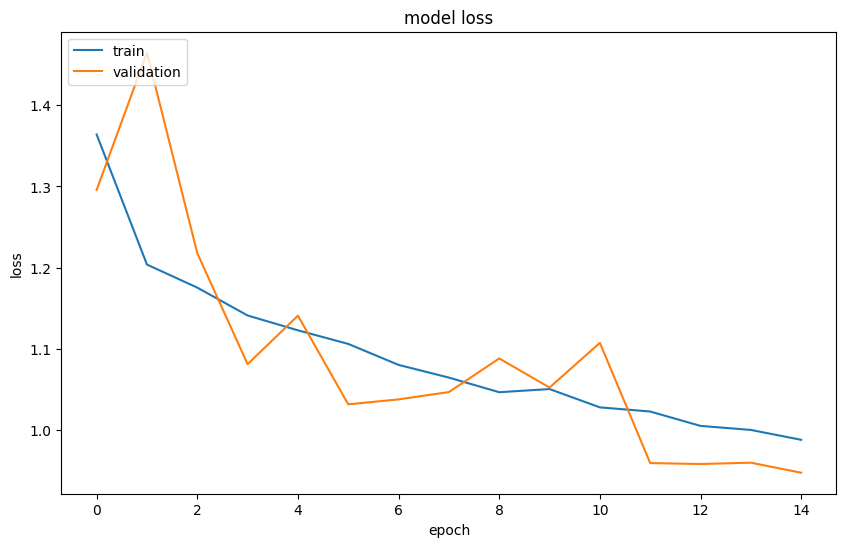

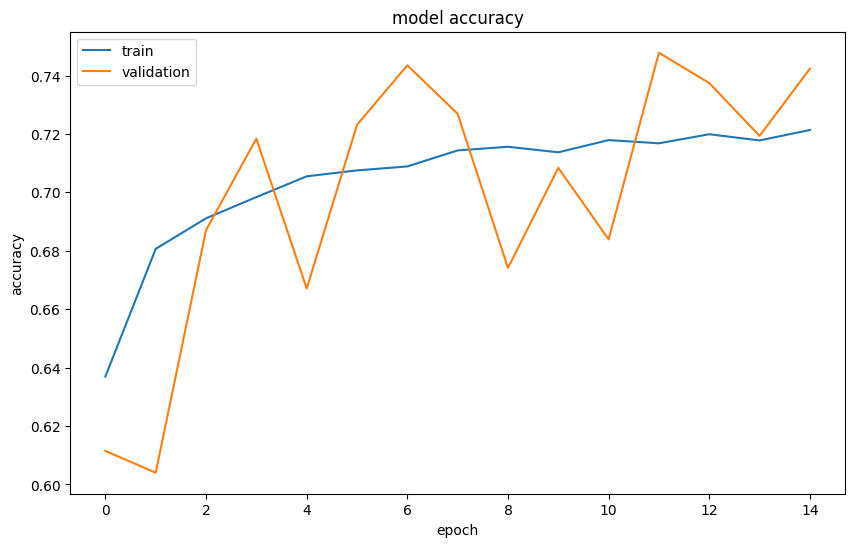

In [12]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

83/83 [==============================] - 1s 7ms/step - loss: 0.9374 - accuracy: 0.7438


[0.937410295009613, 0.7438032031059265]

In [14]:
model.save("2dCNNhard.h5")

In [15]:
import pickle
with open('tokenizerCNNhard.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
from huggingface_hub import push_to_hub_keras
push_to_hub_keras(model, '2dCNNhard')

INFO:tensorflow:Assets written to: /tmp/tmpnvaqmr8a/NorahAlshahrani/2dCNNhard/assets


INFO:tensorflow:Assets written to: /tmp/tmpnvaqmr8a/NorahAlshahrani/2dCNNhard/assets


saved_model.pb:   0%|          | 0.00/190k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/256M [00:00<?, ?B/s]

'https://huggingface.co/NorahAlshahrani/2dCNNhard/tree/main/'

In [17]:
from huggingface_hub import from_pretrained_keras

model_hf = from_pretrained_keras('NorahAlshahrani/2dCNNhard')
model_hf.summary()

config.json not found in HuggingFace Hub.


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 200)     4000200     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 512, 200, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 510, 1, 100)  60100       ['reshape[0][0]']                
                                                                                              

In [18]:
import pickle
import torch
import numpy as np
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences

# loaded_model = tf.keras.models.load_model("biLSTMhardnew.h5")
tokenizer = pickle.load(open('tokenizerCNNhard.pickle', 'rb'))

text = "أنا لا أحب قراءة الكتب"
token = tokenizer.texts_to_sequences([text])
token = pad_sequences(token, maxlen=512)

outputs=model_hf.predict(token)
outputs = torch.from_numpy(outputs)

id2label = {
 0: 'Negative',
 1: 'Negative',
 2: 'Positive',
 3: 'Positive'
}

predClassID= outputs.argmax().item()
pred = outputs.softmax(dim=-1).tolist()
pred = round(np.max(pred)*100, 2)

print(f"Text: '{text}' \nLabel: {id2label[predClassID]} \nPredication: {pred}%")

1/1 [==============================] - 0s 104ms/step
Text: 'أنا لا أحب قراءة الكتب' 
Label: Negative 
Predication: 26.74%
